In [1]:
import numpy as np
import torch
from pathlib import Path
import os
from bnn_priors.models import DenseNet
import matplotlib.pyplot as plt

from pyro.infer.mcmc import NUTS, HMC
from pyro.infer.mcmc.api import MCMC

%load_ext autoreload
%autoreload 2

In [2]:
data = np.load("../data/snelson.npz")

model = DenseNet(1, 1, 32)
if torch.cuda.is_available():
    model = model.cuda()

x_train = torch.from_numpy(data['x_train']).unsqueeze(1).to(model.lin1.weight)
y_train = torch.from_numpy(data['y_train']).unsqueeze(1).to(x_train)

x_test = torch.from_numpy(data['x_test']).unsqueeze(1).to(x_train)

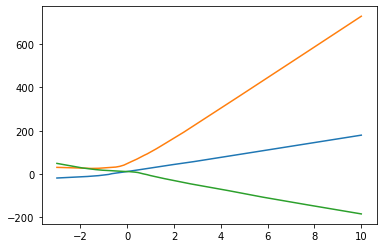

In [3]:
with torch.no_grad():
    for _ in range(3):
        model.sample_all_priors()
        y = model(x_test).loc
        plt.plot(x_test.cpu(), y.cpu())
    plt.show()

In [4]:
N_steps = 20 # 100
warmup = 10 # 50

kernel = NUTS(potential_fn=model.get_potential(x_train, y_train), adapt_step_size=True, step_size=0.1)
mcmc = MCMC(kernel, num_samples=N_steps, warmup_steps=warmup, initial_params=model.params_with_prior_dict())
mcmc.run(x=x_train, y=y_train)

samples = mcmc.get_samples()

Sample: 100%|██████████| 30/30 [00:59,  1.97s/it, step size=1.17e-03, acc. prob=0.841]


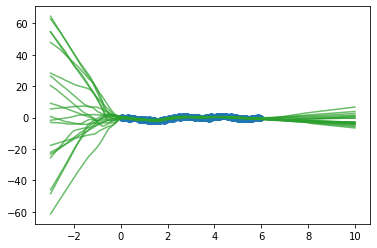

In [5]:
for i in range(N_steps):
    sample = dict((k, v[i]) for k, v in samples.items())
    with torch.no_grad(), model.using_params(sample):
        plt.plot(x_test.cpu(), model(x_test).loc.cpu(), color="C2", alpha=0.7)
plt.scatter(x_train.cpu(), y_train.cpu())
plt.show()